# King County House Price Prediction
## Author: SUNGHO LEE, 2018/12
### Contact Info: DRLEE7979@GMAIL.COM

## Instructions

1. Generate a clear statement problem and provide location for dataset
2. Provide a clear solution to the problem for a non-technical audience
3. Visually explore the data to generate insight and include summary statistics
4. Use an appropriate statistical analysis method
5. Prepare the data via cleaning, normalization, encoding, et cetera
6. Generate and evaluate a working model (hypothesis, linear, or time series)
7. Draw direct inferences and conclusions from model results
8. Use professional coding standards and techniques including:

    - explanatory markdown text
    - proper code comments
    - functions to minimize redundant code
    - minimize hard-coded variables

### Note
Please use the <a class="icon-pdf" title="Independent Project Rubric" href="https://library.startlearninglabs.uw.edu/DATASCI410/Handouts/DATASCI%20410%20Independent%20Project%20Rubric.pdf" target="_blank" rel="noopener">Rubric</a> as a general guide for your project.

# Abstract
- Original source: https://www.kaggle.com/harlfoxem/housesalesprediction

## Problem
- What is the most important factor that affects and correlates with house price?
- Can we build a reliable regression model to represent/predict the house price given the heatures of the house?
- Is is true that the 2 or 3 story house is most likely more expensive than 1-story house?

## Conclusion
- I discovered in my data exploration part that there are many features of the house that are highly inter-correlated which will make my regression model with large variance of the model coefficients. This motivates me to employ SVD regression model or Ridge/Lasso regression models instead of a simple OLS model.
- sqft_living feature is the most strong indicator/predictor of the house price.
- Number of bedrooms/bathrooms also the strong indicator of the house price.
- grade feature is also highly correlated with the house price, but the evaluation of the grade might be somewhat subjective and hard to quantify
- Since there are many features that are highly dependent to each other, Ridge or Lasso Regression models are highly recommended as demonstrated in my coding below.
- All my comments or analysis results are shown below.

Thank you so much

Sincerely,

Sungho Lee

# ----------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------

# ANALYSIS PART 1 - INITIAL EXPLORATION OF DATA SET - START

In [39]:
# Load necessary libraries

#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
#
import statsmodels.formula.api as sm
#

In [40]:
# Create a scale function for a column in a pandas df
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

In [41]:
# Location of dataset:
# Original source: https://www.kaggle.com/harlfoxem/housesalesprediction
# https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv

# Load data
filename = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
KCH = pd.read_csv(filename)
print(KCH.shape)
print(KCH.dtypes)
print(KCH.describe())
print(KCH.head(10))
print(KCH.tail(10))


(21613, 21)
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1

### Note:
- After review of the data above, I concluded that there is an outlier at bedroom column (a 33-bedrooms). This will need to be replaced/removed.
- However, there is an ambiguity on the other columns whether the large values in these columns should be treated as outliear or not. I decided to keep them as it is instead of replacing/removing them.
- Also, after few iterations of my regresion analysis and hypothesis test analysis, I concluded that I would need to remove the rows with house price that is higher than a certain threshold (~ 1.5M dollars). In my view, Once the house price is beyond 1.5M dollars, the behavior of house price becomes more uncertain and I would to limit my model to a typical range of house prices.

### Replacing outlier in Price column with its median:

In [42]:
# calculate the limits for values that are not outliers. 
LimitHi = np.mean(KCH.loc[:, "bedrooms"]) + 10*np.std(KCH.loc[:, "bedrooms"])
LimitLo = np.mean(KCH.loc[:, "bedrooms"]) - 10*np.std(KCH.loc[:, "bedrooms"])
# Create Flag for values outside of limits
FlagBad = (KCH.loc[:, "bedrooms"] < LimitLo) | (KCH.loc[:, "bedrooms"] > LimitHi)
# Replace outlieres with mean of the whole array
KCH.loc[FlagBad, "bedrooms"] = np.mean(KCH.loc[:, "bedrooms"])
#
print(KCH.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.369471      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.907961      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     11.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517    

### Removing rows with house price higher than 1.5M dollars :

In [43]:
# Create Flag for values outside of limits
FlagGood = (KCH.loc[:, "price"] <= 1500000)
# Removing house price higher than 1.5M dollars
KCH=KCH.loc[FlagGood,:]
#
print(KCH.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.109700e+04  2.109700e+04  21097.000000  21097.000000  21097.000000   
mean   4.592365e+09  5.012777e+05      3.348693      2.080391   2022.189174   
std    2.878734e+09  2.482295e+05      0.897713      0.732479    824.830866   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.125059e+09  3.199500e+05      3.000000      1.500000   1410.000000   
50%    3.905040e+09  4.450000e+05      3.000000      2.250000   1890.000000   
75%    7.334501e+09  6.250000e+05      4.000000      2.500000   2500.000000   
max    9.900000e+09  1.500000e+06     11.000000      7.500000   7480.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.109700e+04  21097.000000  21097.000000  21097.000000  21097.000000   
mean   1.474278e+04      1.485306      0.003982      0.200076      3.406977   
std    3.994771e+04      0.538147      0.062976    

### Correlations :

In [44]:
#
Correlation1=KCH[['price','bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','grade','sqft_above'
                  ,'sqft_basement','yr_renovated','lat','long','sqft_living15','sqft_lot15','yr_built', 'floors']].corr()
Correlation1

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,yr_built,floors
price,1.000000,0.317138,0.487236,0.656843,0.277934,0.085815,0.305028,0.034077,0.665694,0.559567,0.272735,0.102344,0.394319,0.049141,0.589665,0.080099,0.059861,0.277934
bedrooms,0.317138,1.000000,0.517130,0.598224,0.167925,-0.038813,0.053177,0.022783,0.346143,0.481542,0.299046,0.009091,-0.020671,0.139119,0.387765,0.025346,0.162984,0.167925
bathrooms,0.487236,0.517130,1.000000,0.730794,0.501425,0.002566,0.127123,-0.134489,0.634148,0.654041,0.246683,0.034602,0.006577,0.239390,0.544108,0.072831,0.529965,0.501425
sqft_living,0.656843,0.598224,0.730794,1.000000,0.347445,0.007618,0.210527,-0.071085,0.731842,0.861042,0.398742,0.030924,0.030787,0.271189,0.749199,0.175950,0.344672,0.347445
floors,0.277934,0.167925,0.501425,0.347445,1.000000,-0.000372,0.001268,-0.271169,0.455838,0.528158,-0.274413,0.001778,0.043350,0.130153,0.270907,-0.019211,0.499833,1.000000
waterfront,0.085815,-0.038813,0.002566,0.007618,-0.000372,1.000000,0.313727,0.014870,-0.000495,-0.003658,0.021463,0.087042,-0.039149,-0.059126,0.018083,0.032473,-0.041368,-0.000372
view,0.305028,0.053177,0.127123,0.210527,0.001268,0.313727,1.000000,0.034758,0.181029,0.098617,0.233003,0.085989,-0.012713,-0.079981,0.225063,0.067707,-0.062422,0.001268
condition,0.034077,0.022783,-0.134489,-0.071085,-0.271169,0.014870,0.034758,1.000000,-0.161429,-0.173473,0.174109,-0.061610,-0.017298,-0.103739,-0.110954,-0.000712,-0.357226,-0.271169
grade,0.665694,0.346143,0.634148,0.731842,0.455838,-0.000495,0.181029,-0.161429,1.000000,0.728532,0.114392,-0.008192,0.100228,0.217643,0.691908,0.106573,0.472825,0.455838
sqft_above,0.559567,0.481542,0.654041,0.861042,0.528158,-0.003658,0.098617,-0.173473,0.728532,1.000000,-0.123024,0.003722,-0.024959,0.376281,0.725902,0.181078,0.450904,0.528158


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

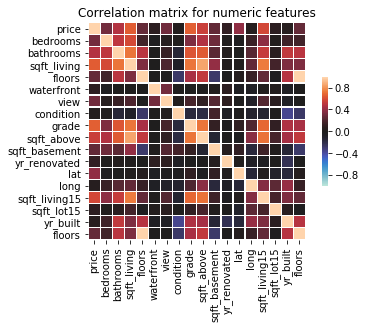

In [45]:
sns.heatmap(Correlation1, vmax=1.0, center=0, vmin=-1.0,
            square=True, linewidths=.25, cbar_kws={"shrink": .5})
plt.title('Correlation matrix for numeric features')
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')

## Note:
- Based on the cross-correlations analyzed above, it indicates that some features are highly dependent to each other.
- In the later part of this code, this will be taken care of by PCA/SVD modeling tools.

Text(0,0.5,'price')

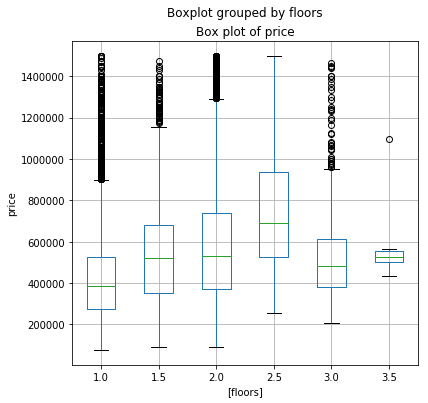

In [46]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6)) # define plot area
ax = fig.gca() # define axis 
KCH.loc[:,['price', 'floors']].boxplot(by = 'floors', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('price')# Set text for y axis
#ax.set_ylim(0.0, 50.0) # Set the limits of the y axis

Text(0,0.5,'price')

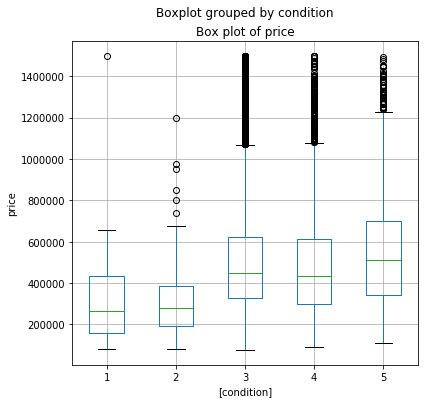

In [47]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6)) # define plot area
ax = fig.gca() # define axis 
KCH.loc[:,['price', 'condition']].boxplot(by = 'condition', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('price')# Set text for y axis
#ax.set_ylim(0.0, 50.0) # Set the limits of the y axis

Text(0,0.5,'price')

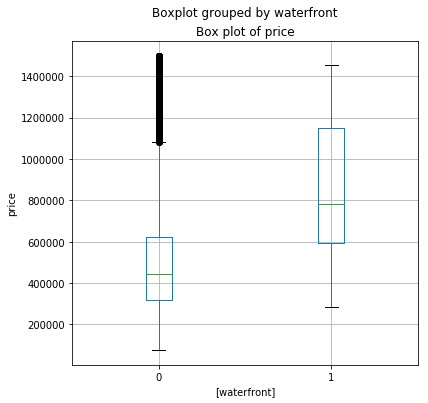

In [48]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6)) # define plot area
ax = fig.gca() # define axis 
KCH.loc[:,['price', 'waterfront']].boxplot(by = 'waterfront', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('price')# Set text for y axis
#ax.set_ylim(0.0, 50.0) # Set the limits of the y axis

Text(0,0.5,'price')

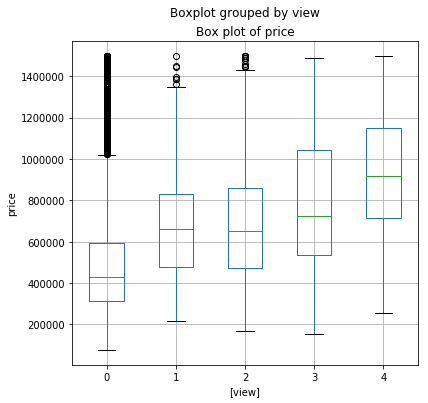

In [49]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6)) # define plot area
ax = fig.gca() # define axis 
KCH.loc[:,['price', 'view']].boxplot(by = 'view', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('price')# Set text for y axis
#ax.set_ylim(0.0, 50.0) # Set the limits of the y axis

Text(0,0.5,'price')

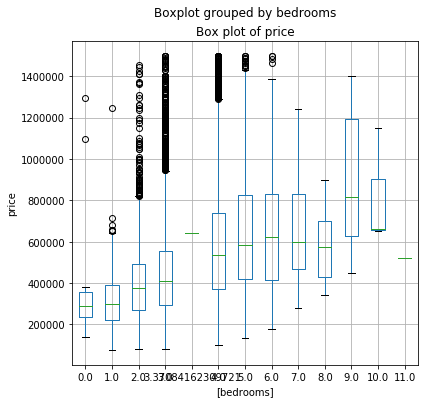

In [50]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6)) # define plot area
ax = fig.gca() # define axis 
KCH.loc[:,['price', 'bedrooms']].boxplot(by = 'bedrooms', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('price')# Set text for y axis
#ax.set_ylim(0.0, 50.0) # Set the limits of the y axis

# ANALYSIS PART 1 - INITIAL EXPLORATION OF DATA SET - END

# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------

# ANALYSIS PART 2 - REGRESSION MODEL - START

In [51]:
# Add scaled x to data frame
# Scaling the label (dependent variable)
KCH['price_scale'] = scale(KCH['price'])
# Scaling the feature (independent variables)
KCH['bedrooms_scale'] = scale(KCH['bedrooms'])
KCH['bathrooms_scale'] = scale(KCH['bathrooms'])
KCH['bedrooms_scale'] = scale(KCH['bedrooms'])
KCH['sqft_living_scale'] = scale(KCH['sqft_living'])
KCH['floors_scale'] = scale(KCH['floors'])
KCH['sqft_above_scale'] = scale(KCH['sqft_above'])
KCH['sqft_basement_scale'] = scale(KCH['sqft_basement'])
KCH['yr_built_scale'] = scale(KCH['yr_built'])
#
KCH.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,price_scale,bedrooms_scale,bathrooms_scale,sqft_living_scale,floors_scale,sqft_above_scale,sqft_basement_scale,yr_built_scale
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,1340,5650,-1.125508,-0.388433,-1.475014,-1.021069,-0.901831,-0.739363,-0.659288,-0.543291
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,1690,7639,0.147940,-0.388433,0.231561,0.664165,0.956442,0.559519,0.287110,-0.679905
2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,...,2720,8062,-1.294308,-1.502401,-1.475014,-1.518152,-0.901831,-1.277284,-0.659288,-1.294669
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,1360,5000,0.413830,0.725536,1.255506,-0.075398,-0.901831,-0.909923,1.493767,-0.201756
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,1800,7503,0.035139,-0.388433,-0.109754,-0.414870,-0.901831,-0.083362,-0.659288,0.549621


In [52]:
y_output = KCH['price_scale']

## Model1 - Single Feature (sqft_living) for Single Label :

Scaled: Intercept, Slope : Intercept            7.112366e-17
sqft_living_scale    6.568426e-01
dtype: float64
Scaled: Intercept t-value, Slope t-value: Intercept            1.369987e-14
sqft_living_scale    1.265213e+02
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Slope:
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          7.112e-17      0.005   1.37e-14      1.000      -0.010       0.010
Intercept:
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.6568      0.005    126.521      0.000       0.647       0.667

Scaled: SSE, SST, SSR, and RMSE:
SSE: 9102

C:\Users\sl\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'price vs. sqft_living (Scaled)')

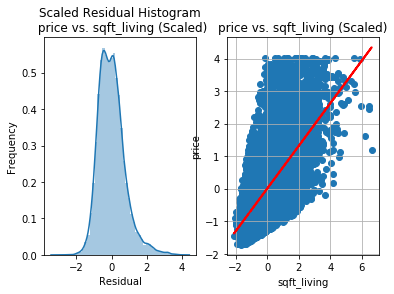

In [53]:
x1_scaled = KCH['sqft_living_scale']
ols_model = sm.ols(formula='price_scale ~ sqft_living_scale', data = KCH)
y_pred_1 = ols_model.fit().predict()
results = ols_model.fit()

# Get slope (m) and y-intercept (b)
print('Scaled: Intercept, Slope : {}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Scaled: Intercept t-value, Slope t-value: {}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print('Slope:')
print(results.t_test([1,0]))
print('Intercept:')
print(results.t_test([0,1]))

print('\nScaled: SSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
plt.subplot(1, 2, 1)
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Scaled Residual Histogram\n price vs. sqft_living (Scaled)')
plt.subplot(1, 2, 2)
plt.scatter(x1_scaled, y_output)
plt.plot(x1_scaled, y_pred_1, '-r', linewidth=2)
plt.grid(True)
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('price vs. sqft_living (Scaled)')

## Note:
- Based on analysis above, simple linear regression model shows a very bad performance
- House price is whidely spreaded around a linearly fitted regression model and this is why the predictability gets pretty bad. R-squared is only 0.493 which I think is pretty low..

## Model2 - Multiple Features for Single Label - OLS Model :

Intercept, Slopes : 
Intercept              7.112366e-17
bedrooms_scale        -1.243611e-01
bathrooms_scale       -1.091840e-03
sqft_living_scale      6.256829e+11
floors_scale           7.963425e-02
sqft_above_scale      -5.781828e+11
sqft_basement_scale   -3.206166e+11
dtype: float64
Intercept t-value, Slope t-values: 
Intercept              1.386491e-14
bedrooms_scale        -1.373799e+01
bathrooms_scale       -1.304535e-01
sqft_living_scale      9.017481e-01
floors_scale           1.164056e+01
sqft_above_scale      -9.017481e-01
sqft_basement_scale   -9.017481e-01
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept              1.000000e+00
bedrooms_scale         9.188975e-43
bathrooms_scale        8.962088e-01
sqft_living_scale      3.672010e-01
floors_scale           3.193636e-31
sqft_above_scale       3.672010e-01
sqft_basement_scale    3.672010e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 9388.763960235825
SST: 21096.9999999999

C:\Users\sl\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

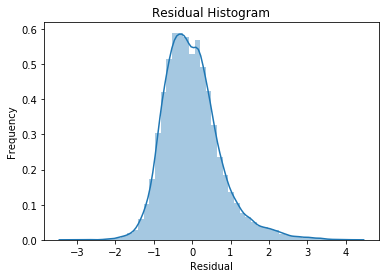

In [54]:
ols_model = sm.ols(formula = 'price_scale ~ bedrooms_scale + bathrooms_scale + bedrooms_scale + sqft_living_scale + floors_scale + sqft_above_scale + sqft_basement_scale + 1', data=KCH)

results = ols_model.fit()
n_points = KCH.shape[0]
y_output = KCH['price_scale']

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

## Note:
- Based on the p-value, all features seems significant, excpet for the bathrooms and intercept. and I don't see any indications of "over-fitting" of model parameters.
- R-squared value (~0.5) seems too high.
- The residual plot seem to be well behaved.

## Model3 - Multiple Features for Single Label - SVD Method :

### 3.1. To create a model matrix of the features for the house price data:

In [55]:
KCH_vars = KCH.loc[:,['bedrooms_scale', 'bathrooms_scale','bedrooms_scale', 'sqft_living_scale', 'floors_scale', 'sqft_above_scale', 'sqft_basement_scale']]
#KCH_vars = KCH.loc[:,['bedrooms_scale', 'bathrooms_scale','bedrooms_scale', 'sqft_living_scale', 'floors_scale', 'sqft_above_scale', 'sqft_basement_scale']]
M = KCH_vars.as_matrix()
HousePrice = KCH.loc[:,'price_scale']

print('1st 5 rows of Data Frame: ')
print(KCH_vars.head())
print('\n1st 5 rows in matrix Form: ')
print(M[0:5, :])

1st 5 rows of Data Frame: 
   bedrooms_scale  bathrooms_scale  bedrooms_scale  sqft_living_scale  \
0       -0.388433        -1.475014       -0.388433          -1.021069   
1       -0.388433         0.231561       -0.388433           0.664165   
2       -1.502401        -1.475014       -1.502401          -1.518152   
3        0.725536         1.255506        0.725536          -0.075398   
4       -0.388433        -0.109754       -0.388433          -0.414870   

   floors_scale  sqft_above_scale  sqft_basement_scale  
0     -0.901831         -0.739363            -0.659288  
1      0.956442          0.559519             0.287110  
2     -0.901831         -1.277284            -0.659288  
3     -0.901831         -0.909923             1.493767  
4     -0.901831         -0.083362            -0.659288  

1st 5 rows in matrix Form: 
[[-0.38843264 -1.47501378 -0.38843264 -1.02106889 -0.90183089 -0.73936275
  -0.65928764]
 [-0.38843264  0.23156092 -0.38843264  0.66416502  0.95644194  0.55951938


C:\Users\sl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### 3.2. To compute the SVD of the resulting matrix and examine the singular values:

In [56]:
# default setting
#beta_coeffs, resids, rank, s = np.linalg.lstsq(M,childHeight)
# more advanced setting (we want to treat 10 times smaller values to be zero in the singular values)
# i.e. forcing into "more biased and more stable regression" by getting rid of small singular values.
# i.e. "truncating the problem dimension"
beta_coeffs, resids, rank, s = np.linalg.lstsq(M,HousePrice,rcond=0.1)

print('beta coefficients: {}'.format(beta_coeffs))

print('\nsingular values: {}'.format(s))

beta coefficients: [-0.05935089 -0.00071287 -0.05935089  0.37153321  0.07979255  0.28181944
  0.21682858]

singular values: [2.85056349e+02 1.80389424e+02 1.32000561e+02 1.03604611e+02
 7.56536213e+01 6.96780355e-13 2.53816856e-14]


### Note:
- The 6th and 7th singular values are close to zero which means my model matrix is rank deficient.
- # Thus, I'll get rid of 6th and 7th feature in my regression modeling!!!!

### Evaluation of this regression model:

SSR: 11707.627839870811
SST: 21096.999999999916
R-squared = 0.4450572195160043


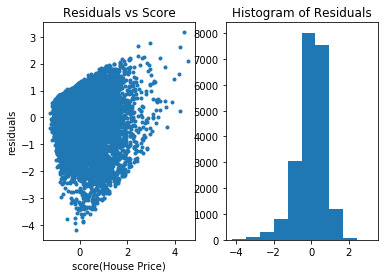

In [57]:
male_predictions = np.dot(M, beta_coeffs) + np.mean(HousePrice)
male_resids = male_predictions - HousePrice

# Plot the residuals vs score (height)
plt.subplot(1, 2, 1)
plt.plot(male_predictions, male_resids, '.')
plt.ylabel('residuals')
plt.xlabel('score(House Price)')
plt.title('Residuals vs Score')

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(male_resids)
plt.title('Histogram of Residuals')

# R-squared
#              SSR
# R^2 = 1 -  -------
#              SST

SSR = np.sum(np.square(male_resids))
SST = np.sum(np.square(HousePrice - np.mean(HousePrice)))

print('SSR: {}'.format(SSR))
print('SST: {}'.format(SST))

R2 = 1.0 - (SSR / SST)

print('R-squared = {}'.format(R2))


## Model4 - Multiple Features for Single Label - Principal Component Regression Method :

### 4.1. To create a model matrix of the features for the house price data:

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [59]:
# Calculate all the Principal components
X = KCH.as_matrix(columns=['bedrooms_scale', 'bathrooms_scale','bedrooms_scale', 'sqft_living_scale', 'floors_scale', 'sqft_above_scale', 'sqft_basement_scale'])
y = KCH['price_scale']
pca = PCA()
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(data = pca_result, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7'])

# Here is our data projected onto the four principal components.
print(pca_df.head())
print(pca_df.shape)

pca_df['price_scale'] = KCH['price_scale']

        pc1       pc2       pc3       pc4       pc5           pc6  \
0 -2.045184  0.302227  0.891776  0.446224 -0.214764  6.722780e-13   
1  0.584803 -0.793564 -0.912534 -0.110919 -0.538528  6.825885e-14   
2 -3.436841 -0.135105  0.010790  0.208317  0.025229  1.126184e-14   
3  0.728779  2.013007 -0.408348 -0.825239  1.037448 -1.314926e-13   
4 -0.916120 -0.071012  0.214960  0.655156  0.648904 -2.648275e-14   

            pc7  
0  3.546679e-15  
1 -7.027333e-15  
2 -1.149854e-15  
3  1.357772e-14  
4  2.741324e-15  
(21097, 7)


C:\Users\sl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### 4.2. Regression Model:

                            OLS Regression Results                            
Dep. Variable:            price_scale   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.624
Date:                Fri, 24 Aug 2018   Prob (F-statistic):              0.136
Time:                        22:16:58   Log-Likelihood:                -29223.
No. Observations:               20602   AIC:                         5.846e+04
Df Residuals:                   20595   BIC:                         5.852e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0050      0.007     -0.712      0.4

C:\Users\sl\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Residual Histogram')

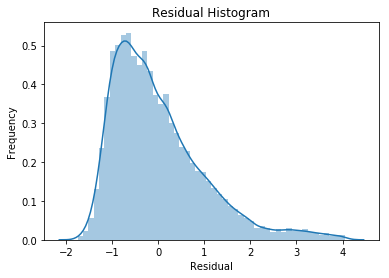

In [60]:
pcr_model = sm.ols(formula = 'price_scale ~ pc1 + pc2 + pc3 + pc4 + pc5 + pc6 + pc7', data=pca_df)

results = pcr_model.fit()
n_points = pca_df.shape[0]
y_output = pca_df['price_scale'].values.reshape(n_points, 1)

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

## Model5 - Multiple Features for Single Label - Ridge / Lasso Regression Methods :

### 5.1. Ridge Regression Model

In [61]:
U, s, V = np.linalg.svd(M, full_matrices=False)

# Calculate the inverse singular value matrix from SVD
lambda_val = 1.0
d = np.diag(1. /  (s + lambda_val))

print('Inverse Singular Value Matrix:')
print(d)

# Compute pseudo-inverse
mInv = np.dot(np.transpose(V), np.dot(d, np.transpose(U)))

print('M Inverse')
print(mInv)

Inverse Singular Value Matrix:
[[0.00349581 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.005513   0.         0.         0.         0.
  0.        ]
 [0.         0.         0.00751877 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.00955981 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.0130457  0.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]
M Inverse
[[ 3.10222288e-01 -6.39598500e-02  2.68272897e-03 ...  5.23691384e-04
  -7.37105575e-04  5.23691384e-04]
 [-6.85398547e-05 -4.86445617e-05 -1.92920349e-05 ... -1.57526545e-04
   7.75997552e-05 -1.57526545e-04]
 [-3.10196030e-01  6.39092078e-02 -2.72425924e-03 ... -5.57286271e-04
   7.23822985e-04 -5.57286271e-04]
 ...
 [-2.34292490e-05  6.66075800e-05 -2.20934374e-05 ...  1.41614009e-04
   3.72598644e-05  1.41614009e-04]
 [-5.69513245e-

In [62]:
beta_coeffs_ridge = np.dot(mInv, HousePrice)
print('Beta\'s: {}'.format(beta_coeffs_ridge))

Beta's: [ 0.69422694  0.0008759  -0.81106892 -0.07327471  0.07922204  0.68839164
  0.44160624]


In [63]:
# Ridge Regression with various penalties in Statsmodels
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'price_scale ~ bedrooms_scale + bathrooms_scale + bedrooms_scale + sqft_living_scale + floors_scale + sqft_above_scale + sqft_basement_scale + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=KCH).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=0)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), HousePrice)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(HousePrice - np.mean(HousePrice)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

Text(0.5,0,'Log-Lambda')

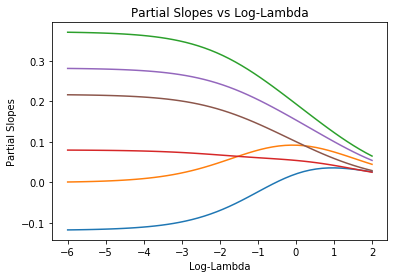

In [64]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slopes')
plt.xlabel('Log-Lambda')

Text(0,0.5,'Partial Slopes')

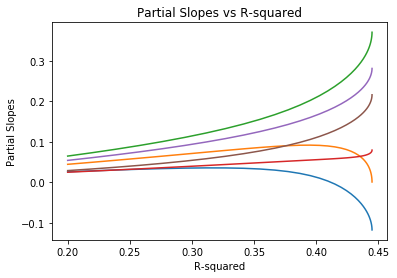

In [65]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
#plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs R-squared')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

### Note:
- Based on the sensitivity test above, it seems that the R_squared value of ~ 0.45 is a well balanced trad-off point to take between variance and bias in this model

### 5.2. Lasso Regression Model

In [66]:
# Lasso Regression with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'price_scale ~ bedrooms_scale + bathrooms_scale + bedrooms_scale + sqft_living_scale + floors_scale + sqft_above_scale + sqft_basement_scale + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=KCH).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=1)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), HousePrice)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(HousePrice - np.mean(HousePrice)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

Text(0.5,0,'Log-Lambda')

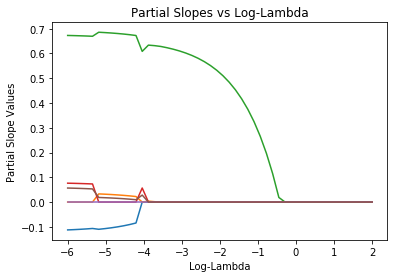

In [67]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

### 5.3. Elastic Net Regression Model

In [68]:
# Elasticnet Regression with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 0, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'price_scale ~ bedrooms_scale + bathrooms_scale + bedrooms_scale + sqft_living_scale + floors_scale + sqft_above_scale + sqft_basement_scale + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=KCH).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=0.75)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), HousePrice)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(HousePrice - np.mean(HousePrice)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

Text(0.5,0,'Log-Lambda')

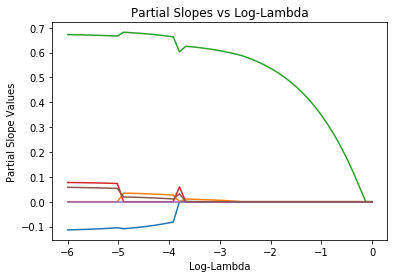

In [69]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

Text(0,0.5,'Partial Slopes')

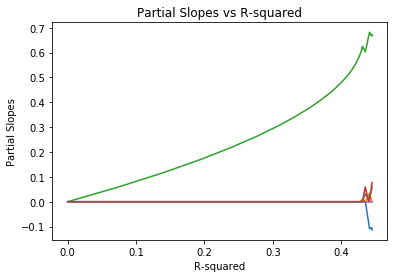

In [70]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
#plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs R-squared')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

# ANALYSIS PART 2 - REGRESSION MODEL - END

# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------

# ANALYSIS PART 3 - HYPOTHESIS TEST - START

### Import libraries

In [71]:
# Import libraries
from scipy.stats import norm
import numpy.random as nr
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
#
import scipy.stats as ss
import seaborn as sns

### Sub-functions to define

In [72]:
%matplotlib inline
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   

def hist_mean_ci(vec, t_test, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

### checking the histogram for normality of house prices:

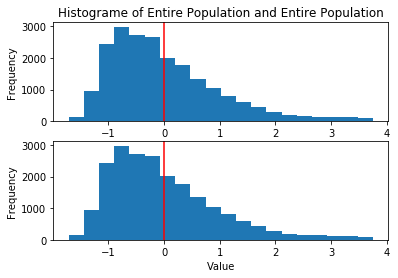

In [73]:
plot_pop(KCH.loc[:, "price_scale"], KCH.loc[:, "price_scale"], ['Entire Population', 'Entire Population'])    
plt.show()

### Grouping the population

### Group1 - by floors :

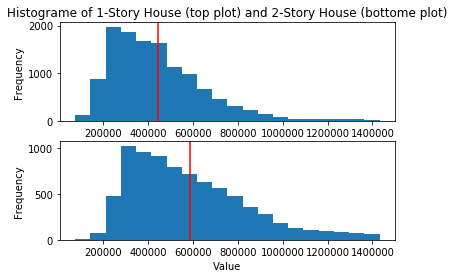

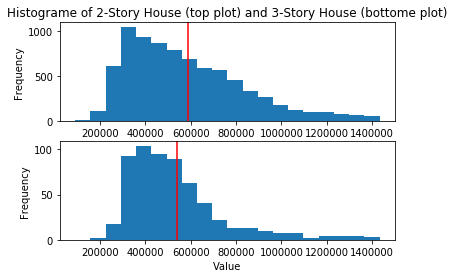

In [84]:
Flag_floors_1story = (KCH.loc[:, "floors"] >= 1) & (KCH.loc[:, "floors"] < 2)
Flag_floors_2story = (KCH.loc[:, "floors"] >= 2) & (KCH.loc[:, "floors"] < 3)
Flag_floors_3story = (KCH.loc[:, "floors"] >= 3) & (KCH.loc[:, "floors"] < 4)
Pop_floors_1story = KCH.loc[Flag_floors_1story, "price"]
Pop_floors_2story = KCH.loc[Flag_floors_2story, "price"]
Pop_floors_3story = KCH.loc[Flag_floors_3story, "price"]
## The histogram comparisons
plot_pop(Pop_floors_1story, Pop_floors_2story, ['1-Story House (top plot)', '2-Story House (bottome plot)'])
plt.show()
plot_pop(Pop_floors_2story, Pop_floors_3story, ['2-Story House (top plot)', '3-Story House (bottome plot)'])
plt.show()

### Note:
- Very interesting observation on the histrogram of 1-story house versus 3-story house. My hypothesis was that 3-story house is more expensive than 2-story house.

### Group2 - by bedrooms :

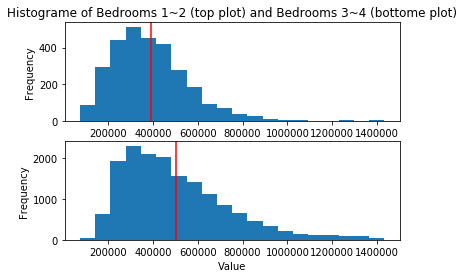

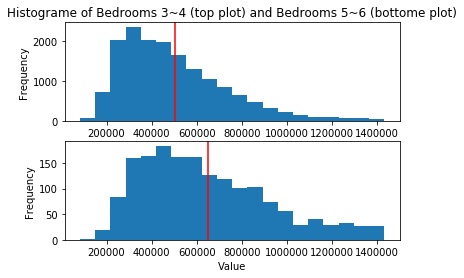

In [75]:
Flag_bedrooms_1_2 = (KCH.loc[:, "bedrooms"] >= 1) & (KCH.loc[:, "bedrooms"] <= 2)
Flag_bedrooms_3_4 = (KCH.loc[:, "bedrooms"] >= 3) & (KCH.loc[:, "bedrooms"] <= 4)
Flag_bedrooms_5_6 = (KCH.loc[:, "bedrooms"] >= 5) & (KCH.loc[:, "bedrooms"] <= 6)
Pop_bedrooms_1_2 = KCH.loc[Flag_bedrooms_1_2, "price"]
Pop_bedrooms_3_4 = KCH.loc[Flag_bedrooms_3_4, "price"]
Pop_bedrooms_5_6 = KCH.loc[Flag_bedrooms_5_6, "price"]
## The histogram comparisons
plot_pop(Pop_bedrooms_1_2, Pop_bedrooms_3_4, ['Bedrooms 1~2 (top plot)', 'Bedrooms 3~4 (bottome plot)'])
plt.show()
plot_pop(Pop_bedrooms_3_4, Pop_bedrooms_5_6, ['Bedrooms 3~4 (top plot)', 'Bedrooms 5~6 (bottome plot)'])
plt.show()

### t-Statistics:

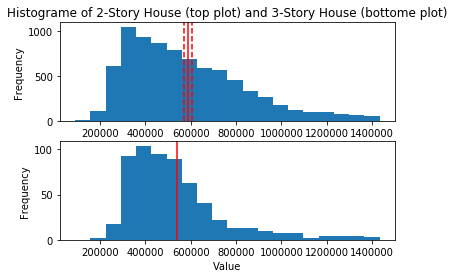

DegFreedom      731.904771
Difference    49565.622440
Statistic         4.401163
PValue            0.000011
Low95CI       30610.195902
High95CI      68521.048978
dtype: float64


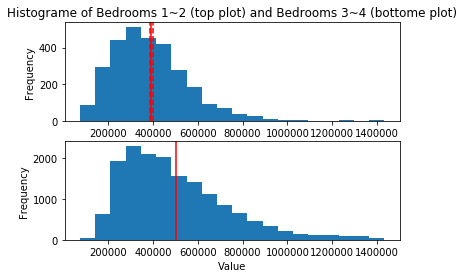

DegFreedom     5.114557e+03
Difference    -1.125114e+05
Statistic     -2.388670e+01
PValue        2.661668e-124
Low95CI       -1.200308e+05
High95CI      -1.049920e+05
dtype: float64


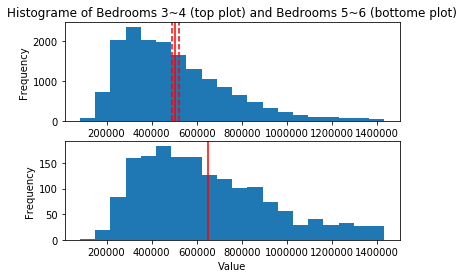

DegFreedom     1.965869e+03
Difference    -1.433735e+05
Statistic     -2.263934e+01
PValue        6.371229e-112
Low95CI       -1.578282e+05
High95CI      -1.289189e+05
dtype: float64


In [87]:
test_floors = t_test(Pop_floors_2story, Pop_floors_3story, 0.05)
plot_t(Pop_floors_2story, Pop_floors_3story, test_floors, ['2-Story House (top plot)', '3-Story House (bottome plot)'])  
plt.show()
print(test_floors)
#
test_bedrooms1 = t_test(Pop_bedrooms_1_2, Pop_bedrooms_3_4, 0.05)
plot_t(Pop_bedrooms_1_2, Pop_bedrooms_3_4, test_bedrooms1, ['Bedrooms 1~2 (top plot)', 'Bedrooms 3~4 (bottome plot)'])  
plt.show()
print(test_bedrooms1)
#
test_bedrooms2 = t_test(Pop_bedrooms_3_4, Pop_bedrooms_5_6, 0.05)
plot_t(Pop_bedrooms_3_4, Pop_bedrooms_5_6, test_bedrooms2, ['Bedrooms 3~4 (top plot)', 'Bedrooms 5~6 (bottome plot)'])  
plt.show()
print(test_bedrooms2)

### Note:
- The differnece in house prices between 2-story house and 3-story house seems pretty significant. T-statistic is also pretty large and more importantly the p-value is pretty small which indicates that there is a extremely low chance that the difference in means is from random variation alone.
- Thus, I should reject the null hypothesis that a 3-story house is more expensive than a 2-story house. In fact, the difference is still significant, but in the opposite way.
- The differnece in house prices between different number of bedrooms also seems pretty significant.